# 2: Removing Outliers and Transforming data

## 2.1 Using Mahalanobis distance to identify outliers
As we are working with Multivariate data, it isn't the best practice for us to simply remove outliers based on a single variable. Thus, we utilise Mahalanobis distance to identify outliers based on multiple variables.

### 2.1.1: Loading and preparing dataset for mahalanobis distance calculation

In [37]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import re
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler


# Read the CSV file
raw_df = pd.read_csv('../data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')

# Load Dataset and perform simple transformations to numerical for mahalanobis distance
def convert_lease_to_months(lease_str):
    years, months = 0, 0  # Default values

    # Extract years
    year_match = re.search(r'(\d+)\s*years?', lease_str)
    if year_match:
        years = int(year_match.group(1))

    # Extract months
    month_match = re.search(r'(\d+)\s*months?', lease_str)
    if month_match:
        months = int(month_match.group(1))

    return years * 12 + months  # Convert to total months

# Apply function to column
raw_df["remaining_lease_months"] = raw_df["remaining_lease"].apply(convert_lease_to_months)

df = raw_df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200540 entries, 0 to 200836
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   month                   200540 non-null  object 
 1   town                    200540 non-null  object 
 2   flat_type               200540 non-null  object 
 3   block                   200540 non-null  object 
 4   street_name             200540 non-null  object 
 5   storey_range            200540 non-null  object 
 6   floor_area_sqm          200540 non-null  float64
 7   flat_model              200540 non-null  object 
 8   lease_commence_date     200540 non-null  int64  
 9   remaining_lease         200540 non-null  object 
 10  resale_price            200540 non-null  float64
 11  remaining_lease_months  200540 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 19.9+ MB


In [38]:
df_numeric = df[['floor_area_sqm', 'remaining_lease_months', 'resale_price']].copy() 


# Compute the mean and covariance matrix
mean_vec = np.mean(df_numeric, axis=0)
cov_matrix = np.cov(df_numeric, rowvar=False)

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each data point
df_numeric['mahalanobis_dist'] = df_numeric.apply(lambda x: mahalanobis(x, mean_vec, inv_cov_matrix), axis=1)


# View top outliers
df_numeric.sort_values(by='mahalanobis_dist', ascending=False).head(70)

,floor_area_sqm,remaining_lease_months,resale_price,mahalanobis_dist
182474,366.7,564,1568000.0,11.688276
200280,117.0,1038,1600000.0,7.101499
174508,112.0,1088,1588000.0,7.090145
197905,106.0,1020,1550000.0,7.060178
174615,113.0,1050,1580000.0,7.047303
...,...,...,...,...
148453,113.0,1135,1450000.0,6.051356
148368,113.0,1137,1450000.0,6.050331
183103,117.0,1023,1450000.0,6.048822
171900,172.0,808,1500000.0,6.019152


Based on the Mahalanobis Distance, we can see that there is a single outlier with a significantly different when compared to the other datapoints. Thus, we will remove this single outlier before we proceed.

In [39]:
# Find the index of the top outlier
top_outlier_idx = df_numeric['mahalanobis_dist'].idxmax()

# Remove the outlier from the dataset
df_cleaned = df.drop(index=top_outlier_idx)

# Verify the removal
print(f"Removed row at index: {top_outlier_idx}")
print(df_cleaned.shape)  # Check the new shape

# Load your dataset 
df_numeric_cleaned = df_cleaned[['floor_area_sqm', 'remaining_lease_months', 'resale_price']].copy() 

# Compute the mean and covariance matrix
mean_vec = np.mean(df_numeric_cleaned, axis=0)
cov_matrix = np.cov(df_numeric_cleaned, rowvar=False)

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance for each data point
df_numeric_cleaned['mahalanobis_dist'] = df_numeric_cleaned.apply(lambda x: mahalanobis(x, mean_vec, inv_cov_matrix), axis=1)
# View top outliers
df_numeric_cleaned.sort_values(by='mahalanobis_dist', ascending=False).head(70)

Removed row at index: 182474
(200539, 12)


,floor_area_sqm,remaining_lease_months,resale_price,mahalanobis_dist
200280,117.0,1038,1600000.0,7.101510
174508,112.0,1088,1588000.0,7.090138
197905,106.0,1020,1550000.0,7.060166
174615,113.0,1050,1580000.0,7.047301
175779,105.0,1023,1542880.0,7.033331
...,...,...,...,...
148368,113.0,1137,1450000.0,6.050326
183103,117.0,1023,1450000.0,6.048841
171900,172.0,808,1500000.0,6.019791
175710,97.0,1030,1370000.0,6.017171


## 2.2: Retaining only relevant columns

In [40]:
# relevant features

df_cleaned = df_cleaned[["month", 'town', 'storey_range', 'floor_area_sqm', 'flat_type','flat_model','remaining_lease','resale_price']].copy() 
df_cleaned.head()

,month,town,storey_range,floor_area_sqm,flat_type,flat_model,remaining_lease,resale_price
0,2017-01,ANG MO KIO,10 TO 12,44.0,2 ROOM,Improved,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,04 TO 06,68.0,3 ROOM,New Generation,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,62 years 05 months,265000.0


## 2.3: Data cleaning for macrodata

### 2.3.1: Loading and preparing dataset for mahalanobis distance calculation

In [41]:
# Load the CSV File
df_macro_unfiltered = pd.read_csv('../macro_data/macro_data.csv')  # Read the CSV file into a DataFrame

df_macro = df_macro_unfiltered[['0', 'GDP In Chained (2015) Dollars', '    Assets', '    Liabilities', 'Total Unemployment Rate, (SA)']].copy() 

df_macro.head()

,0,GDP In Chained (2015) Dollars,Assets,Liabilities,"Total Unemployment Rate, (SA)"
0,20244Q,146375.8,3431440.9,379400.7,1.9
1,20243Q,142350.4,3350578.6,374027.5,1.9
2,20242Q,137603.1,3288024.2,368376.3,2.0
3,20241Q,135612.1,3237721.6,365018.3,2.1
4,20234Q,139345.6,3178795.1,364286.8,2.0


#### Segregate Data Quarterly: 
Group the data by quarters using pandas and verify the segregation.
Convert the data to appropriate format

In [42]:
# Convert '20241Q' format to datetime
def convert_quarter_to_date(quarter_str):
    year = int(quarter_str[:4])  # Extract the year
    quarter = int(quarter_str[4])  # Extract the quarter number
    month = (quarter - 1) * 3 + 1  # Calculate the starting month of the quarter
    return pd.Timestamp(year=year, month=month, day=1)

# Apply the conversion function to the 'Date' column
df_macro['0'] = df_macro['0'].apply(convert_quarter_to_date)

# Rename the column header 0 to 'Date'
df_macro.rename(columns={'0': 'Date'}, inplace=True)

# Display the cleaned DataFrame
print(df_macro)

         Date  GDP In Chained (2015) Dollars      Assets      Liabilities  \
0  2024-10-01                       146375.8   3431440.9         379400.7   
1  2024-07-01                       142350.4   3350578.6         374027.5   
2  2024-04-01                       137603.1   3288024.2         368376.3   
3  2024-01-01                       135612.1   3237721.6         365018.3   
4  2023-10-01                       139345.6   3178795.1         364286.8   
5  2023-07-01                       134613.1   3090032.2         361253.2   
6  2023-04-01                       133017.3   3059937.5         359824.6   
7  2023-01-01                       131343.8   3014560.0         358500.4   
8  2022-10-01                       135140.6   2939020.1         360402.6   
9  2022-07-01                       132091.7   2896129.7         363401.4   
10 2022-04-01                       131362.3   2848876.0         361781.9   
11 2022-01-01                       130095.6   2813474.3         358655.0   

Extrapolate to monthly data

In [43]:
# Convert 'Date' column to datetime
df_macro['Date'] = pd.to_datetime(df_macro['Date'])

# Extrapolate to monthly data
monthly_data = []
for _, row in df_macro.iterrows():
    start_date = row['Date']
    row_data = row.to_dict()  # Convert the row to a dictionary
    for i in range(3):  # Repeat for 3 months
        month_date = start_date + pd.DateOffset(months=i)
        new_row = row_data.copy()  # Copy the row data
        new_row['Date'] = month_date  # Update the date for the new row
        monthly_data.append(new_row)

# Create a new DataFrame with monthly data
monthly_df = pd.DataFrame(monthly_data)

# Sort the DataFrame by date
monthly_df = monthly_df.sort_values(by='Date').reset_index(drop=True)

# Display the resulting DataFrame
print(monthly_df)

         Date  GDP In Chained (2015) Dollars      Assets      Liabilities  \
0  2017-01-01                       111034.4   1985339.9         326458.6   
1  2017-02-01                       111034.4   1985339.9         326458.6   
2  2017-03-01                       111034.4   1985339.9         326458.6   
3  2017-04-01                       113218.7   2012412.8         329965.5   
4  2017-05-01                       113218.7   2012412.8         329965.5   
..        ...                            ...         ...              ...   
91 2024-08-01                       142350.4   3350578.6         374027.5   
92 2024-09-01                       142350.4   3350578.6         374027.5   
93 2024-10-01                       146375.8   3431440.9         379400.7   
94 2024-11-01                       146375.8   3431440.9         379400.7   
95 2024-12-01                       146375.8   3431440.9         379400.7   

    Total Unemployment Rate, (SA)  
0                             2.3  
1  

Import and clean the Core inflation dataset

In [44]:
df_CPI = pd.read_csv('../macro_data/CPI.csv')

from datetime import datetime

# Define the format string for conversion
format_str = '%Y%b'

# Convert the column to datetime format
df_CPI['Date'] = pd.to_datetime(df_CPI['Date'], format=format_str)


#df_CPI['DataSeries'] = pd.to_datetime(df_CPI['DataSeries'])
#df_CPI.rename(columns={'DataSeries': 'Date'}, inplace=True)
df_inflation = df_CPI[['Date', 'MAS Core Inflation Measure']].copy()

df_inflation.head()

,Date,MAS Core Inflation Measure
0,2024-12-01,112.867
1,2024-11-01,112.274
2,2024-10-01,112.299
3,2024-09-01,112.620
4,2024-08-01,112.457


Join the macro datasets

In [45]:
# Merge the DataFrames on the 'Date' column
df_macro = pd.merge(monthly_df, df_inflation, on='Date', how='inner')
df_macro.head()

,Date,GDP In Chained (2015) Dollars,Assets,Liabilities,"Total Unemployment Rate, (SA)",MAS Core Inflation Measure
0,2017-01-01,111034.4,1985339.9,326458.6,2.3,96.763
1,2017-02-01,111034.4,1985339.9,326458.6,2.3,96.836
2,2017-03-01,111034.4,1985339.9,326458.6,2.3,96.883
3,2017-04-01,113218.7,2012412.8,329965.5,2.2,97.332
4,2017-05-01,113218.7,2012412.8,329965.5,2.2,97.177


Using Mahalanobis distance to identify outliers (same as above)

In [46]:
df_numeric = df_macro.drop(columns=['Date'])  # Drop the 'Date' column for analysis
# Compute the mean and covariance matrix
mean_vec = np.mean(df_numeric, axis=0)
cov_matrix = np.cov(df_numeric, rowvar=False)

# Compute the pseudo-inverse of the covariance matrix
inv_cov_matrix = np.linalg.pinv(cov_matrix)

# Compute Mahalanobis distance for each data point
df_numeric['mahalanobis_dist'] = df_numeric.apply(lambda x: mahalanobis(x, mean_vec, inv_cov_matrix), axis=1)


# View top outliers
df_numeric.sort_values(by='mahalanobis_dist', ascending=False).head(70)

,GDP In Chained (2015) Dollars,Assets,Liabilities,"Total Unemployment Rate, (SA)",MAS Core Inflation Measure,mahalanobis_dist
40,105851.5,2386825.4,327494.1,3.0,99.703,4.490455
41,105851.5,2386825.4,327494.1,3.0,99.720,4.489637
39,105851.5,2386825.4,327494.1,3.0,99.766,4.487738
44,115450.2,2434122.4,329308.5,3.4,99.818,3.544336
43,115450.2,2434122.4,329308.5,3.4,99.654,3.460889
...,...,...,...,...,...,...
18,119638.5,2168119.5,344220.5,2.1,99.311,1.824274
34,122407.5,2337418.2,339320.9,2.2,99.952,1.800306
26,117965.0,2213274.8,342590.7,2.2,100.030,1.789230
33,122407.5,2337418.2,339320.9,2.2,100.013,1.778355


(same steps as above for df_cleaned)

In [47]:
# Find the index of the top outlier
top_outlier_idx = df_numeric['mahalanobis_dist'].idxmax()

# Remove the outlier from the dataset
df_cleaned_macro = df_macro.drop(index=top_outlier_idx)

# Verify the removal
print(f"Removed row at index: {top_outlier_idx}")
print(df_cleaned.shape)  # Check the new shape

# Load your dataset 
df_numeric_cleaned = df_cleaned_macro.drop(columns=['Date'])  # Drop 'Date' column for numeric analysis

# Compute the mean and covariance matrix
mean_vec = np.mean(df_numeric_cleaned, axis=0)
cov_matrix = np.cov(df_numeric_cleaned, rowvar=False)

# Compute the pseudo-inverse of the covariance matrix
inv_cov_matrix = np.linalg.pinv(cov_matrix)

# Compute Mahalanobis distance for each data point
df_numeric_cleaned['mahalanobis_dist'] = df_numeric_cleaned.apply(lambda x: mahalanobis(x, mean_vec, inv_cov_matrix), axis=1, result_type='expand')

# View top outliers
df_numeric_cleaned.sort_values(by='mahalanobis_dist', ascending=False).head(70)

Removed row at index: 40
(200539, 8)


,GDP In Chained (2015) Dollars,Assets,Liabilities,"Total Unemployment Rate, (SA)",MAS Core Inflation Measure,mahalanobis_dist
41,105851.5,2386825.4,327494.1,3.0,99.720,5.091960
39,105851.5,2386825.4,327494.1,3.0,99.766,5.089728
44,115450.2,2434122.4,329308.5,3.4,99.818,3.612313
43,115450.2,2434122.4,329308.5,3.4,99.654,3.532304
42,115450.2,2434122.4,329308.5,3.4,99.505,3.464547
...,...,...,...,...,...,...
18,119638.5,2168119.5,344220.5,2.1,99.311,1.815480
33,122407.5,2337418.2,339320.9,2.2,100.013,1.794408
26,117965.0,2213274.8,342590.7,2.2,100.030,1.794063
24,117965.0,2213274.8,342590.7,2.2,99.961,1.754001


## Join both datasets

In [48]:
# Convert both columns to datetime
df_cleaned['month'] = pd.to_datetime(df_cleaned['month'], format='%Y-%m')  # Convert '2017-01' to datetime
df_cleaned_macro['Date'] = pd.to_datetime(df_cleaned_macro['Date'], format='%Y-%m-%d')  # Convert '2017-01-01' to datetime

# Standardize the format (truncate df2['date'] to year-month)
df_cleaned_macro['Date'] = df_cleaned_macro['Date'].dt.to_period('M').dt.to_timestamp()  # Convert to '2017-01'

# Merge the DataFrames
merged_df = pd.merge(df_cleaned, df_cleaned_macro, left_on='month', right_on='Date', how='inner')

# Convert the 'Date' column (or any datetime column) back to string format
merged_df['month'] = merged_df['month'].dt.strftime('%Y-%m')  # Specify the desired format, e.g., 'YYYY-MM-DD'

# Display the merged DataFrame
print(merged_df)



          month        town storey_range  floor_area_sqm         flat_type  \
0       2017-01  ANG MO KIO     10 TO 12            44.0            2 ROOM   
1       2017-01  ANG MO KIO     01 TO 03            67.0            3 ROOM   
2       2017-01  ANG MO KIO     01 TO 03            67.0            3 ROOM   
3       2017-01  ANG MO KIO     04 TO 06            68.0            3 ROOM   
4       2017-01  ANG MO KIO     01 TO 03            67.0            3 ROOM   
...         ...         ...          ...             ...               ...   
196323  2024-12      YISHUN     07 TO 09           142.0         EXECUTIVE   
196324  2024-12      YISHUN     07 TO 09           146.0         EXECUTIVE   
196325  2024-02      YISHUN     04 TO 06           164.0  MULTI-GENERATION   
196326  2024-03      YISHUN     10 TO 12           164.0  MULTI-GENERATION   
196327  2024-06      YISHUN     07 TO 09           171.0  MULTI-GENERATION   

              flat_model     remaining_lease  resale_price     

## 2.4: Transforming Datatypes

In [49]:
df = merged_df.copy()  
df.dtypes

month                                    object
town                                     object
storey_range                             object
floor_area_sqm                          float64
flat_type                                object
flat_model                               object
remaining_lease                          object
resale_price                            float64
Date                             datetime64[ns]
GDP In Chained (2015) Dollars           float64
    Assets                              float64
    Liabilities                         float64
Total Unemployment Rate, (SA)           float64
MAS Core Inflation Measure              float64
dtype: object

### 2.4.1: Changing month to months from Jan 2017

In [50]:
# changing month to months from jan 2017
df[['y', 'm_from2017']]=df['month'].str.split(pat="-", expand = True)
df['y'] = pd.to_numeric(df['y']).sub(2017).mul(12)
df['m_from2017'] = pd.to_numeric(df['m_from2017'])
df['m_from2017'] = df['m_from2017'].add(df['y'])
# can delete col y now

### 2.4.2: Changing remaining lease to no. of months left in lease

In [51]:
# changing remaining lease to no of months left
def convert_to_months(lease_str):
    years = 0
    months = 0
    
    # Extract years and months using regex
    year_match = re.search(r'(\d+) years?', lease_str)
    month_match = re.search(r'(\d+) months?', lease_str)

    if year_match:
        years = int(year_match.group(1))
    if month_match:
        months = int(month_match.group(1))

    return (years * 12) + months

# Apply the function to transform the column
df['lease_months_left'] = df['remaining_lease'].apply(convert_to_months)
# remove remaining_lease

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196328 entries, 0 to 196327
Data columns (total 17 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   month                          196328 non-null  object        
 1   town                           196328 non-null  object        
 2   storey_range                   196328 non-null  object        
 3   floor_area_sqm                 196328 non-null  float64       
 4   flat_type                      196328 non-null  object        
 5   flat_model                     196328 non-null  object        
 6   remaining_lease                196328 non-null  object        
 7   resale_price                   196328 non-null  float64       
 8   Date                           196328 non-null  datetime64[ns]
 9   GDP In Chained (2015) Dollars  196328 non-null  float64       
 10      Assets                     196328 non-null  float64       
 11  

### 2.4.3: Encoding towns using one hot encoding

In [53]:
# encoding the towns - one hot encoding

# Standardize column names
df.rename(columns=lambda x: x.strip().lower(), inplace=True)

# Ensure 'town' column is a string and clean spaces
df['town'] = df['town'].astype(str).str.strip()

# One-hot encode
df_encoded = pd.get_dummies(df, columns=['town'], dtype = int)

# Ensure only specified towns are kept
towns = [
    "JURONG WEST", "SENGKANG", "WOODLANDS", "PUNGGOL", "TAMPINES", "YISHUN", "BEDOK", "HOUGANG",
    "ANG MO KIO", "BUKIT MERAH", "CHOA CHU KANG", "TOA PAYOH", "BUKIT BATOK", "BUKIT PANJANG",
    "KALLANG/WHAMPOA", "PASIR RIS", "GEYLANG", "QUEENSTOWN", "SEMBAWANG", "JURONG EAST",
    "BISHAN", "CLEMENTI", "SERANGOON", "CENTRAL AREA", "MARINE PARADE", "BUKIT TIMAH"
]

town_columns = [f'town_{town}' for town in towns if f'town_{town}' in df_encoded.columns]
df_encoded = df_encoded[['town'] + town_columns] if 'town' in df_encoded.columns else df_encoded[town_columns]

df = pd.concat([df, df_encoded], axis = 1)
df.head()

,month,town,storey_range,floor_area_sqm,flat_type,flat_model,remaining_lease,resale_price,date,gdp in chained (2015) dollars,...,town_GEYLANG,town_QUEENSTOWN,town_SEMBAWANG,town_JURONG EAST,town_BISHAN,town_CLEMENTI,town_SERANGOON,town_CENTRAL AREA,town_MARINE PARADE,town_BUKIT TIMAH
0,2017-01,ANG MO KIO,10 TO 12,44.0,2 ROOM,Improved,61 years 04 months,232000.0,2017-01-01,111034.4,...,0,0,0,0,0,0,0,0,0,0
1,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,60 years 07 months,250000.0,2017-01-01,111034.4,...,0,0,0,0,0,0,0,0,0,0
2,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,62 years 05 months,262000.0,2017-01-01,111034.4,...,0,0,0,0,0,0,0,0,0,0
3,2017-01,ANG MO KIO,04 TO 06,68.0,3 ROOM,New Generation,62 years 01 month,265000.0,2017-01-01,111034.4,...,0,0,0,0,0,0,0,0,0,0
4,2017-01,ANG MO KIO,01 TO 03,67.0,3 ROOM,New Generation,62 years 05 months,265000.0,2017-01-01,111034.4,...,0,0,0,0,0,0,0,0,0,0


### 2.4.4: Encoding flat model using one hot encoding

In [54]:
# encoding the flat_model - one hot encoding
#### still need to edit this chunk to adapt it

# Standardize column names
df.rename(columns=lambda x: x.strip().lower(), inplace=True)

# Ensure 'town' column is a string and clean spaces
df['flat_model'] = df['flat_model'].astype(str).str.strip()

# One-hot encode
df_encoded = pd.get_dummies(df, columns=['flat_model'], dtype = int)

# Ensure only specified towns are kept
models = [
    "Model A", "Improved", "New Generation", "Premium Apartment", "Simplified", "Apartment", "Maisonette", "Standard",
    "DBSS", "Model A2", "Model A-Maisonette", "Adjoined flat", "Type S1", "2-room",
    "Type S2", "Premium Apartment Loft", "Terrace", "Multi Generation", "3Gen", "Improved-Maisonette",
    "Premium Maisonette"
]

model_columns = [f'flat_model_{model}' for model in models if f'flat_model_{model}' in df_encoded.columns]
df_encoded = df_encoded[['flat_model'] + model_columns] if 'flat_model' in df_encoded.columns else df_encoded[model_columns]

df = pd.concat([df, df_encoded], axis = 1)
df.tail()

,month,town,storey_range,floor_area_sqm,flat_type,flat_model,remaining_lease,resale_price,date,gdp in chained (2015) dollars,...,flat_model_Adjoined flat,flat_model_Type S1,flat_model_2-room,flat_model_Type S2,flat_model_Premium Apartment Loft,flat_model_Terrace,flat_model_Multi Generation,flat_model_3Gen,flat_model_Improved-Maisonette,flat_model_Premium Maisonette
196323,2024-12,YISHUN,07 TO 09,142.0,EXECUTIVE,Apartment,62 years 03 months,950000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196324,2024-12,YISHUN,07 TO 09,146.0,EXECUTIVE,Maisonette,62 years 03 months,990000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196325,2024-02,YISHUN,04 TO 06,164.0,MULTI-GENERATION,Multi Generation,62 years 11 months,998000.0,2024-02-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196326,2024-03,YISHUN,10 TO 12,164.0,MULTI-GENERATION,Multi Generation,62 years 09 months,1200000.0,2024-03-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196327,2024-06,YISHUN,07 TO 09,171.0,MULTI-GENERATION,Multi Generation,62 years 07 months,1028000.0,2024-06-01,137603.1,...,0,0,0,0,0,0,1,0,0,0


### 2.4.5: Encoding Flat Type using label encoding

In [55]:
# encoding the flat type - label encoding
flat_type_mapping = {
    '1 ROOM': 0,
    '2 ROOM': 1,
    '3 ROOM': 2,
    '4 ROOM': 3,
    '5 ROOM': 4,
    'EXECUTIVE': 5,
    'MULTI-GENERATION': 6
}

# Apply the mapping to the flat_type column
df['flat_type'] = df['flat_type'].map(flat_type_mapping)
df.tail()


,month,town,storey_range,floor_area_sqm,flat_type,flat_model,remaining_lease,resale_price,date,gdp in chained (2015) dollars,...,flat_model_Adjoined flat,flat_model_Type S1,flat_model_2-room,flat_model_Type S2,flat_model_Premium Apartment Loft,flat_model_Terrace,flat_model_Multi Generation,flat_model_3Gen,flat_model_Improved-Maisonette,flat_model_Premium Maisonette
196323,2024-12,YISHUN,07 TO 09,142.0,5,Apartment,62 years 03 months,950000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196324,2024-12,YISHUN,07 TO 09,146.0,5,Maisonette,62 years 03 months,990000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196325,2024-02,YISHUN,04 TO 06,164.0,6,Multi Generation,62 years 11 months,998000.0,2024-02-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196326,2024-03,YISHUN,10 TO 12,164.0,6,Multi Generation,62 years 09 months,1200000.0,2024-03-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196327,2024-06,YISHUN,07 TO 09,171.0,6,Multi Generation,62 years 07 months,1028000.0,2024-06-01,137603.1,...,0,0,0,0,0,0,1,0,0,0


In [56]:
df['flat_model'].value_counts()

flat_model
Model A                   69073
Improved                  48157
New Generation            24241
Premium Apartment         22060
Simplified                 7543
Apartment                  7235
Maisonette                 5515
Standard                   5314
DBSS                       3211
Model A2                   2245
Model A-Maisonette          352
Adjoined flat               339
Type S1                     322
Type S2                     172
2-room                      167
Premium Apartment Loft      107
Terrace                     105
Multi Generation             80
3Gen                         47
Improved-Maisonette          28
Premium Maisonette           15
Name: count, dtype: int64

### 2.4.6: Encoding Storey Range using Label encoding

In [57]:
# encoding the storey_range - label encoding
storey_range_mapping = {
    '01 TO 03': 0, '04 TO 06': 1, '07 TO 09': 2, '10 TO 12': 3, '13 TO 15': 4,
    '16 TO 18': 5, '19 TO 21': 6, '22 TO 24': 7, '25 TO 27': 8, '28 TO 30': 9,
    '31 TO 33': 10, '34 TO 36': 11, '37 TO 39': 12, '40 TO 42': 13, '43 TO 45': 14,
    '46 TO 48': 15, '49 TO 51': 16
}

# Apply the mapping to the storey_range column
df['storey_range'] = df['storey_range'].map(storey_range_mapping)
df.tail()

,month,town,storey_range,floor_area_sqm,flat_type,flat_model,remaining_lease,resale_price,date,gdp in chained (2015) dollars,...,flat_model_Adjoined flat,flat_model_Type S1,flat_model_2-room,flat_model_Type S2,flat_model_Premium Apartment Loft,flat_model_Terrace,flat_model_Multi Generation,flat_model_3Gen,flat_model_Improved-Maisonette,flat_model_Premium Maisonette
196323,2024-12,YISHUN,2,142.0,5,Apartment,62 years 03 months,950000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196324,2024-12,YISHUN,2,146.0,5,Maisonette,62 years 03 months,990000.0,2024-12-01,146375.8,...,0,0,0,0,0,0,0,0,0,0
196325,2024-02,YISHUN,1,164.0,6,Multi Generation,62 years 11 months,998000.0,2024-02-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196326,2024-03,YISHUN,3,164.0,6,Multi Generation,62 years 09 months,1200000.0,2024-03-01,135612.1,...,0,0,0,0,0,0,1,0,0,0
196327,2024-06,YISHUN,2,171.0,6,Multi Generation,62 years 07 months,1028000.0,2024-06-01,137603.1,...,0,0,0,0,0,0,1,0,0,0


### 2.4.7: Encoding macro_data

In [58]:
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 1. One-Hot Encoding for Categorical Features
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. Standardization for Numerical Features
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# 3. (Optional) Normalization for Numerical Features
scaler = MinMaxScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Display the encoded DataFrame
print(df_encoded.head())

   storey_range  floor_area_sqm  flat_type  resale_price       date  \
0        0.1875        0.059633   0.166667      0.063536 2017-01-01   
1        0.0000        0.165138   0.333333      0.075967 2017-01-01   
2        0.0000        0.165138   0.333333      0.084254 2017-01-01   
3        0.0625        0.169725   0.333333      0.086326 2017-01-01   
4        0.0000        0.165138   0.333333      0.086326 2017-01-01   

   gdp in chained (2015) dollars  assets  liabilities  \
0                       0.127896     0.0          0.0   
1                       0.127896     0.0          0.0   
2                       0.127896     0.0          0.0   
3                       0.127896     0.0          0.0   
4                       0.127896     0.0          0.0   

   total unemployment rate, (sa)  mas core inflation measure  ...  \
0                         0.3125                         0.0  ...   
1                         0.3125                         0.0  ...   
2                      

### 2.4.8: Normalising the floor area column

In [59]:
# scaler = MinMaxScaler()
# df[['floor_area_sqm']] = scaler.fit_transform(df[['floor_area_sqm']])

# # Normalising the values within the lease_months_left column

### 2.4.9: Removing redundant columns used for transformation

In [60]:
df['town'].value_counts()

town
SENGKANG           16180
PUNGGOL            14551
WOODLANDS          13954
YISHUN             13388
TAMPINES           13185
JURONG WEST        13027
BEDOK              10319
HOUGANG             9872
CHOA CHU KANG       8969
ANG MO KIO          8055
BUKIT BATOK         7897
BUKIT MERAH         7518
BUKIT PANJANG       7127
TOA PAYOH           6128
KALLANG/WHAMPOA     5988
PASIR RIS           5740
SEMBAWANG           5513
QUEENSTOWN          5387
GEYLANG             4838
CLEMENTI            4376
JURONG EAST         4020
SERANGOON           3548
BISHAN              3505
CENTRAL AREA        1559
MARINE PARADE       1198
BUKIT TIMAH          486
Name: count, dtype: int64

In [61]:
#remove redundant/encoded cols
df.drop(columns=['remaining_lease', 'y', 'town','flat_model', 'month'], inplace=True)

In [62]:
df.dtypes

storey_range                                  int64
floor_area_sqm                              float64
flat_type                                     int64
resale_price                                float64
date                                 datetime64[ns]
gdp in chained (2015) dollars               float64
assets                                      float64
liabilities                                 float64
total unemployment rate, (sa)               float64
mas core inflation measure                  float64
m_from2017                                    int64
lease_months_left                             int64
town_jurong west                              int64
town_sengkang                                 int64
town_woodlands                                int64
town_punggol                                  int64
town_tampines                                 int64
town_yishun                                   int64
town_bedok                                    int64
town_hougang

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196328 entries, 0 to 196327
Data columns (total 59 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   storey_range                       196328 non-null  int64         
 1   floor_area_sqm                     196328 non-null  float64       
 2   flat_type                          196328 non-null  int64         
 3   resale_price                       196328 non-null  float64       
 4   date                               196328 non-null  datetime64[ns]
 5   gdp in chained (2015) dollars      196328 non-null  float64       
 6   assets                             196328 non-null  float64       
 7   liabilities                        196328 non-null  float64       
 8   total unemployment rate, (sa)      196328 non-null  float64       
 9   mas core inflation measure         196328 non-null  float64       
 10  m_from2017          

## 2.5 Feature engineering

### 2.5.1 Removing features based on correlation

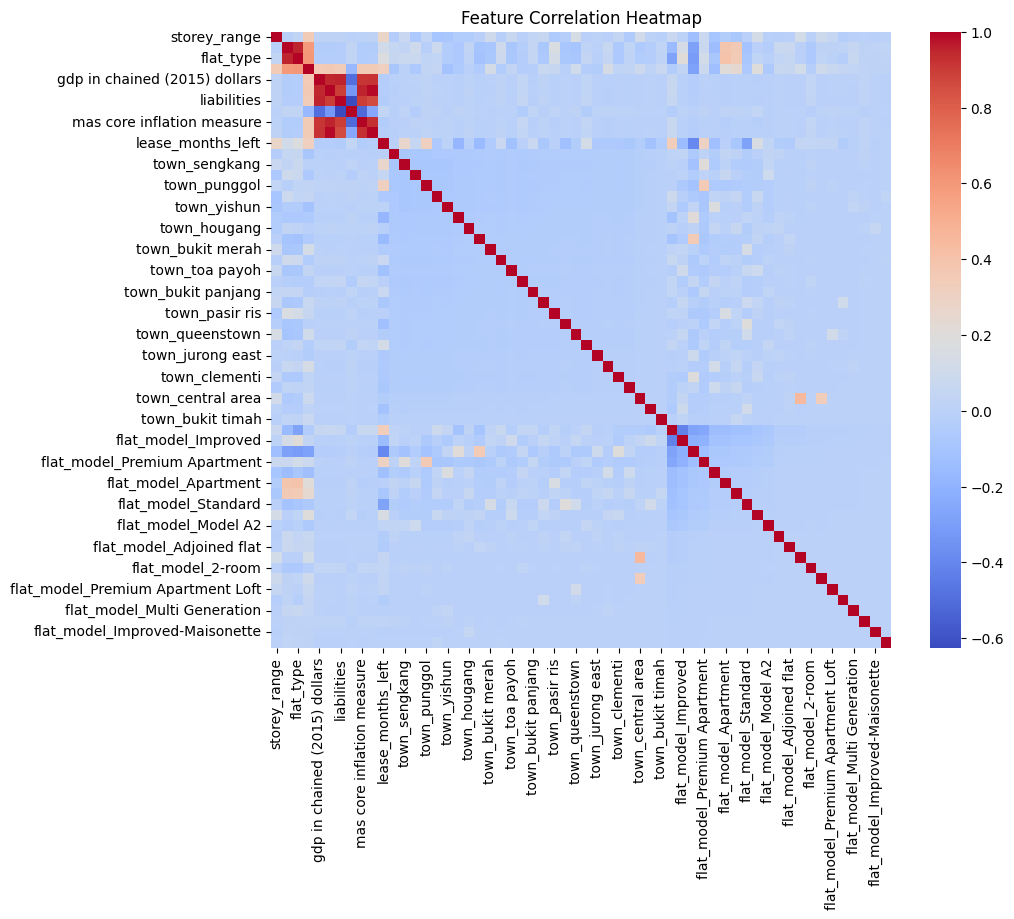

In [64]:
heatcols = df.drop(columns=['date'])
plt.figure(figsize=(10, 8))
sns.heatmap(heatcols.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [65]:
### removing flat type, because of high correlation with floor area
### keeping assets and months from 2017, even though they are highly correlated with each other
### also removing total unemployment rate, because of low correlation with all other features, including the target column resale price
df.drop(columns=['flat_type', 'total unemployment rate, (sa)'], inplace=True)

In [66]:
### changing flat_model encoded columns since most are highly uncorrelated, by adding an 'others' column
### since neighbourhoods chosen are not correlated with specific flat models, choose features based on correlation with resale price

# List of columns to keep (exclude from combining)
others_combine = ["flat_model_Model A", "flat_model_Improved", "flat_model_New Generation", "flat_model_Premium Apartment", "flat_model_Simplified", "flat_model_Standard",
    "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Adjoined flat", "flat_model_Type S1", "flat_model_2-room",
    "flat_model_Type S2", "flat_model_Premium Apartment Loft", "flat_model_Terrace", "flat_model_Multi Generation", "flat_model_3Gen", "flat_model_Improved-Maisonette",
    "flat_model_Premium Maisonette"]

# Get the columns to combine
columns_to_combine = [col for col in df.columns if col in others_combine]

# Create a new column by summing the other one-hot columns
df['flat_model_others'] = df[columns_to_combine].sum(axis=1)

# Optionally, drop the individual columns if you no longer need them
df = df.drop(columns=others_combine)
df.head()

,storey_range,floor_area_sqm,resale_price,date,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,lease_months_left,...,town_bishan,town_clementi,town_serangoon,town_central area,town_marine parade,town_bukit timah,flat_model_Apartment,flat_model_Maisonette,flat_model_DBSS,flat_model_others
0,3,44.0,232000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,1,736,...,0,0,0,0,0,0,0,0,0,1
1,0,67.0,250000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,1,727,...,0,0,0,0,0,0,0,0,0,1
2,0,67.0,262000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,1,749,...,0,0,0,0,0,0,0,0,0,1
3,1,68.0,265000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,1,745,...,0,0,0,0,0,0,0,0,0,1
4,0,67.0,265000.0,2017-01-01,111034.4,1985339.9,326458.6,96.763,1,749,...,0,0,0,0,0,0,0,0,0,1


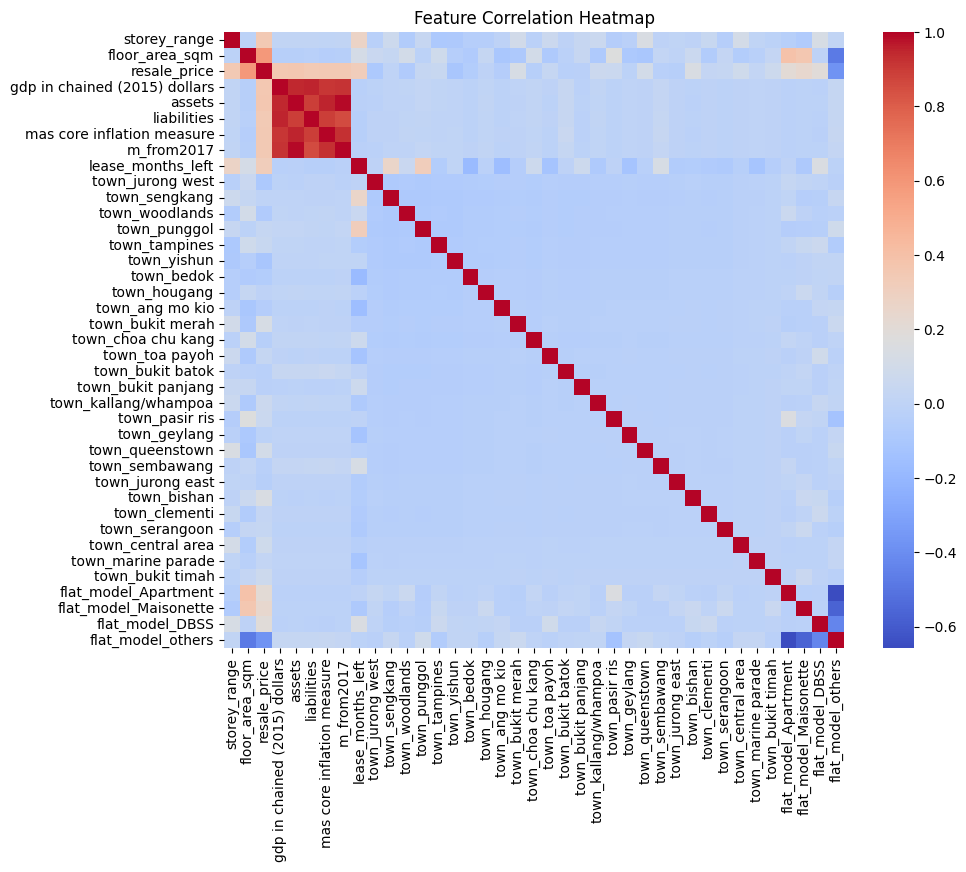

In [67]:
heatcols = df.drop(columns=['date'])
plt.figure(figsize=(10, 8))
sns.heatmap(heatcols.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

since no correlation with resale price, then remove the others column for flat model as well

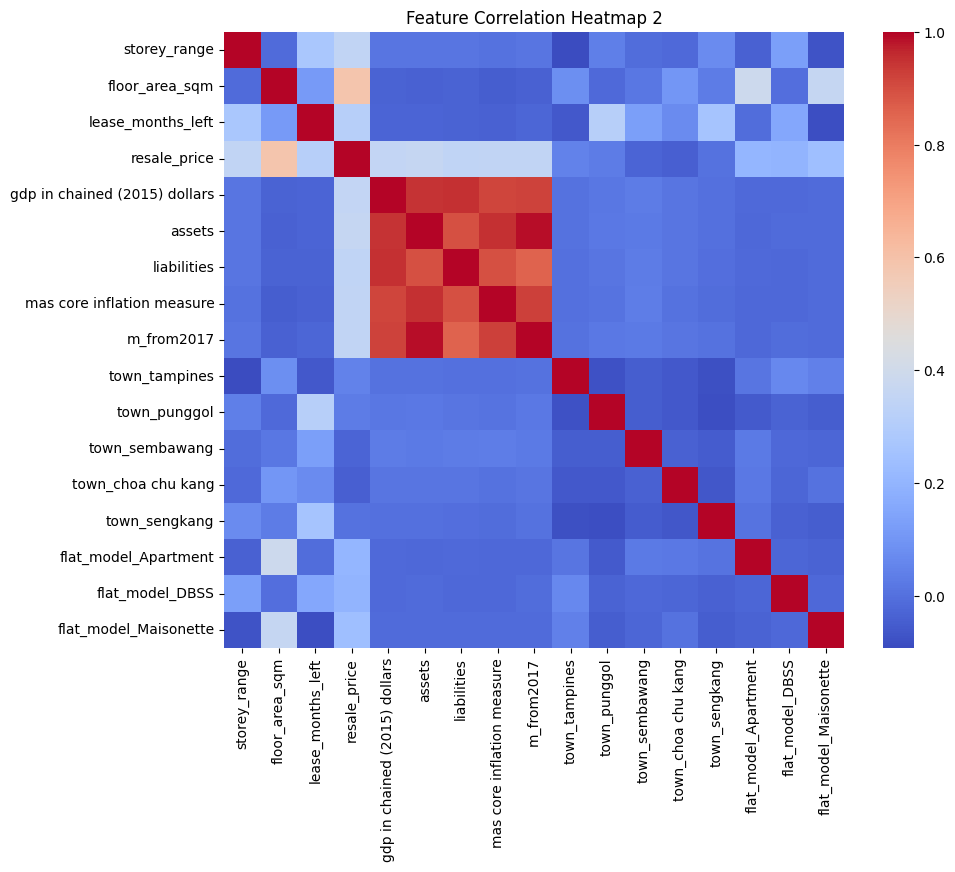

In [68]:
### only keeping towns with younger families, since most of the encoded columns are uncorrelated with resale price
df = df[['storey_range', 'floor_area_sqm', 'lease_months_left', 'resale_price', 'date', 
       'gdp in chained (2015) dollars', 'assets', 'liabilities',
       'mas core inflation measure', 'm_from2017',
       'town_tampines', 'town_punggol', 'town_sembawang', 'town_choa chu kang', 'town_sengkang',
       'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Maisonette',]]
heatcols = df.drop(columns=['date'])
plt.figure(figsize=(10, 8))
sns.heatmap(heatcols.corr(), annot=False, cmap="coolwarm")
plt.title("Feature Correlation Heatmap 2")
plt.show()

## 2.6: Exporting transformed data with test train split to new csv

In [69]:
from sklearn.model_selection import train_test_split

# Split the data into training (80%), validation (10%), and test (10%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Optionally, you can print the shapes of the resulting datasets
print("Training set shape:", train_df.shape)
print("Validation set shape:", valid_df.shape)
print("Test set shape:", test_df.shape)

Training set shape: (157062, 18)
Validation set shape: (19633, 18)
Test set shape: (19633, 18)


In [72]:
# normalise the splitted data
cols_to_norm = ['storey_range', 'floor_area_sqm', 'm_from2017']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler only on the training data
scaler.fit(train_df[cols_to_norm])

# Apply the transformation (without refitting) to all splits
train_df[cols_to_norm] = scaler.transform(train_df[cols_to_norm])
test_df[cols_to_norm] = scaler.transform(test_df[cols_to_norm])
valid_df[cols_to_norm] = scaler.transform(valid_df[cols_to_norm])
display(train_df)
train_df.info()

,storey_range,floor_area_sqm,lease_months_left,resale_price,date,gdp in chained (2015) dollars,assets,liabilities,mas core inflation measure,m_from2017,town_tampines,town_punggol,town_sembawang,town_choa chu kang,town_sengkang,flat_model_Apartment,flat_model_DBSS,flat_model_Maisonette
125356,0.0000,0.287736,1137,630000.0,2022-06-01,131362.3,2848876.0,361781.9,104.764,0.684211,0,0,0,0,0,0,0,0
152249,0.0000,0.273585,773,458000.0,2023-10-01,139345.6,3178795.1,364286.8,110.033,0.852632,0,0,0,0,0,0,0,0
171945,0.5625,0.287736,1121,788888.0,2024-08-01,142350.4,3350578.6,374027.5,112.457,0.957895,0,0,0,0,0,0,0,0
35928,0.2500,0.278302,1020,340000.0,2018-09-01,119638.5,2168119.5,344220.5,99.345,0.210526,0,0,1,0,0,0,0,0
102463,0.2500,0.075472,1097,250000.0,2021-07-01,126391.3,2700535.6,352038.5,100.542,0.568421,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,0.0625,0.264151,1116,908000.0,2022-01-01,130095.6,2813474.3,358655.0,102.516,0.631579,0,0,0,0,0,0,0,0
103694,0.0625,0.160377,632,280000.0,2021-08-01,126391.3,2700535.6,352038.5,100.784,0.578947,0,0,0,0,0,0,0,0
131932,0.1875,0.169811,1088,480000.0,2022-12-01,135140.6,2939020.1,360402.6,107.316,0.747368,0,1,0,0,0,0,0,0
146867,0.3125,0.339623,878,593000.0,2023-12-01,139345.6,3178795.1,364286.8,110.866,0.873684,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
Index: 157062 entries, 125356 to 121958
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   storey_range                   157062 non-null  float64       
 1   floor_area_sqm                 157062 non-null  float64       
 2   lease_months_left              157062 non-null  int64         
 3   resale_price                   157062 non-null  float64       
 4   date                           157062 non-null  datetime64[ns]
 5   gdp in chained (2015) dollars  157062 non-null  float64       
 6   assets                         157062 non-null  float64       
 7   liabilities                    157062 non-null  float64       
 8   mas core inflation measure     157062 non-null  float64       
 9   m_from2017                     157062 non-null  float64       
 10  town_tampines                  157062 non-null  int64         
 11  

In [71]:
# generate the new csv files to use for the model
train_df.to_csv('../data/train_data_w_macro.csv', index = False)
valid_df.to_csv('../data/valid_data_w_macro.csv', index = False)
test_df.to_csv('../data/test_data_w_macro.csv', index = False)